## 04. PyTorch Custom Datasets

=> get own data into pytorch

### 0. Importing and setting up

In [1]:
import torch
from torch import nn

In [2]:
device = "gpu" if torch.cuda.is_available() \
    else "mps" if torch.backends.mps.is_built() else "cpu"
device

'mps'

### 1. Get data

- `Food-101 Dataset:` https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/
    - 101 different classes of food
    - 1000 images per class (750 training)

#### => use a subset of the Food-101 dataset
- use 3 classes of food 
- obly 10% of the images (75 training)

In [3]:
import requests
import zipfile
from pathlib import Path

In [4]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(image_path, " directory already exists...")
else:
    print(image_path, " does not exist, creating...")
    image_path.mkdir(parents=True, exist_ok=True)

data/pizza_steak_sushi  directory already exists...


In [5]:
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading...")
    f.write(request.content)

# unzip the file data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping...")
    zip_ref.extractall(image_path)

Downloading...
Unzipping...


### 2. Data preparation and data exploration

In [6]:
import os

def walk_through_dir(dir_path):
    """ walks through dir_path returning its contents """
    # directory tree generator
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print("There are", len(dirnames), "directories and ", len(filenames), " images in", dirpath)


In [7]:
walk_through_dir(image_path)

There are 2 directories and  0  images in data/pizza_steak_sushi
There are 3 directories and  0  images in data/pizza_steak_sushi/test
There are 0 directories and  19  images in data/pizza_steak_sushi/test/steak
There are 0 directories and  31  images in data/pizza_steak_sushi/test/sushi
There are 0 directories and  25  images in data/pizza_steak_sushi/test/pizza
There are 3 directories and  0  images in data/pizza_steak_sushi/train
There are 0 directories and  75  images in data/pizza_steak_sushi/train/steak
There are 0 directories and  72  images in data/pizza_steak_sushi/train/sushi
There are 0 directories and  78  images in data/pizza_steak_sushi/train/pizza


- `pizza_steak_sushi` -> overall dataset folder
    - `train`   -> training images
        - `pizza`   -> class name as folder name
        - `steak`
        - `sushi`
    - `test`    -> testing images

In [8]:
# set up train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

#### 2.1 Visualize images

- (1) get all of the image paths
- (2) pick a random image path using Python's `random.choice()`
- (3) get the image class name using `pathlib.Path.parent.stem`
- (4) open the image using Python `PIL(pillow)`
- (5) show image and print metadata

In [9]:
# visualize random image
import random
from PIL import Image

# get all the image path
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg')]

Random image path is: data/pizza_steak_sushi/test/pizza/194643.jpg
Image class is: pizza
Image width is: 382
Image height is: 512


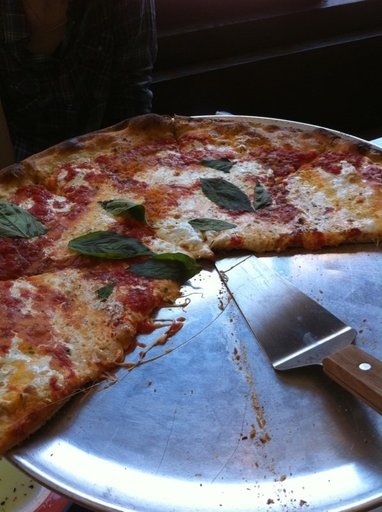

In [10]:
# pick a random image
random_image_path = random.choice(image_path_list)

# get class
image_class = random_image_path.parent.stem

# open image
img = Image.open(random_image_path)

# print metadata
print("Random image path is:", random_image_path)
print("Image class is:", image_class)
print("Image width is:", img.width)
print("Image height is:", img.height)

img

(-0.5, 381.5, 511.5, -0.5)

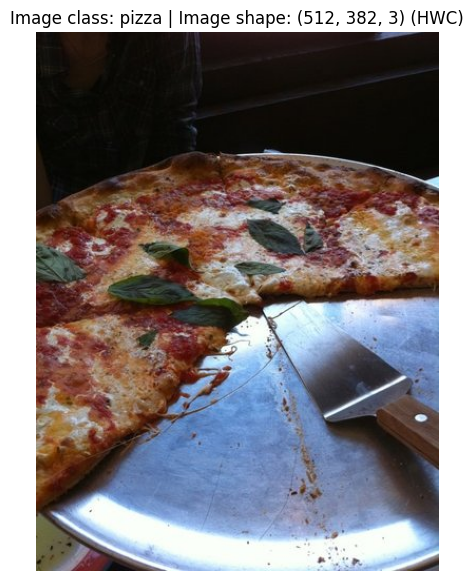

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# turn the image into an array
img_array = np.array(img)

# plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_array)
plt.title(f"Image class: {image_class} | Image shape: {img_array.shape} (HWC)")
plt.axis(False)

### 3. Transform data

- (1) turn target data into tensors
- (2) turn it into a `torch.utils.data.Dataset` and then `torch.utils.data.DataLoader`

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#### 3.1 Transform data with `torchvision.transform`

=> https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

In [13]:
# write a transform for image
data_transform = transforms.Compose([
    # resize image to 64 x 64
    transforms.Resize(size=(64, 64)),
    # flip the image randomly on the horizontal?
    transforms.RandomHorizontalFlip(p = 0.5),
    # tnru into a torch tensor
    transforms.ToTensor()
])

In [14]:
data_transform(img).shape

torch.Size([3, 64, 64])

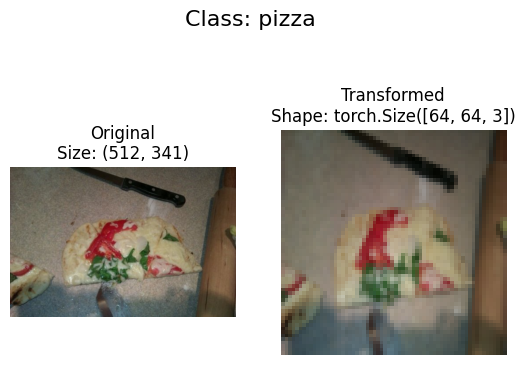

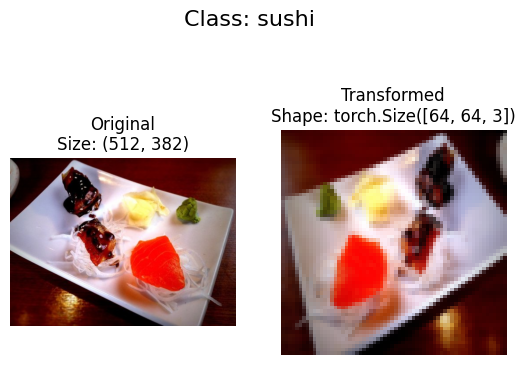

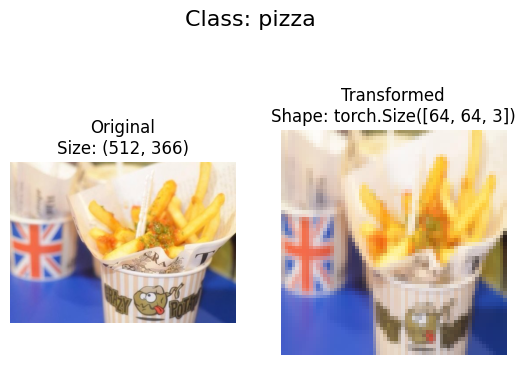

In [15]:
def plot_transform_img(image_path:list, transform, n=3, seed=None):
    """
    select random images from a path of images and load/transform them
    then, plots the original VS the transformed version
    """

    if seed:
        random.seed(seed)
    random_img_path = random.sample(image_path, k=n)

    for image_path in random_img_path:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # transform and plot
            # need to change the shape to color channel first
            transform_img = transform(f).permute(1, 2, 0)
            ax[1].imshow(transform_img)
            ax[1].set_title(f"Transformed\nShape: {transform_img.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transform_img(image_path_list, data_transform, n=3, seed=None)

### 4. Option 1: Loading image data using `ImageFolder`

#### => can load image classification data using `torchvision.datasets.ImageFolder`

In [16]:
# using imagefolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # trasform for the data
                                  target_transform=None)    # trasform for the label

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [24]:
# get a list of class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
# get class name as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
len(train_data), len(test_data)

(225, 75)

In [20]:
train_data.samples[:10]

[('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1089334.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1105700.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/12301.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1285298.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/138855.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1412034.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1524655.jpg', 0)]

In [22]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original image shape: torch.Size([3, 64, 64])
Image permute shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

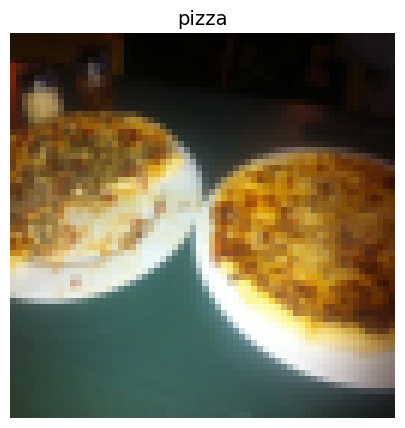

In [25]:
# rearrange the order dimension
img_permute = img.permute(1,2,0)

print(f"Original image shape: {img.shape}")
print(f"Image permute shape: {img_permute.shape}")

plt.figure(figsize=(8,5))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)